# Feature Matching

Input files of this notebook:

- file...

Output files of this notebook:

- file...

## Why?

## How?

## What could it mean?

The feature matching takes it starting point in the reference data and attempts to identify corresponding features in the OSM data set.

Matching features in two road datasets with each their way of digitizing features and a potential one-to-many relationship between edges (for example in the case where one data set only maps road center lines, while the other map the geometries of each bike lane) is not a trivial task.

The method used here converts all network edges to smaller segments of a uniform length before looking for a potential match between the reference and the OSM data. The matching is done on the basis of the buffered distance between objects, the angle, and the undirected Hausdorff distance, and is based on the work of Koukoletsos et al. (2012) and Will (2014).

Based on the matching results we compute:
- The number and length of matched and unmatched edges, in total and per grid cell
- A comparison of the attributes of the matched edges (is their classification of cycling infrastructure as protected or unprotected the same?)

One the feature matching is complete, it is important to visually explore the results, since the success rate of the matching influences how the analysis of number of matches should be interpreted.

If the features in the two data sets have been digitized in very differnet ways - e.g. if one data set has digitised bike tracks as mostly straight lines, while the other includes more winding tracks, the matching will fail. This is also the case if they are placed too far from each other. If we visually can confirm that the same features do exist in both data sets, a lack of matches indicates that the geometries in the two data sets are too different. If we on the other hand can confirm that most real corresponding features have been identified, a lack of matches in an area indicates errors of commission or omission.

*The feature matching is faily computationally expensive and will take a while to compute. For the testing data provided in this repository (with around 8000 meters of OSM network the cell takes around 20 minutes to run).*

**Sections:**

1. Load and process data
2. Feature matching
    - Plot results: matched vs. unmatched features
3. Analyse results
    - Matched features by infrastructure type
    - Matche features per grid cell
4. Save results

_______________

## 1. Load and process data

In [10]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
import os.path
from src import evaluation_functions as ef
from src import matching_functions as mf
from src import graph_functions as gf

### Load settings

In [11]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']

    reference_geometries = parsed_yaml_file['reference_geometries']
    cycling_bidirectional = parsed_yaml_file['bidirectional']

    feature_matching = parsed_yaml_file['feature_matching']
    
print('Settings loaded!')

Settings loaded!


### Load OSM and reference graphs and grid

In [12]:
# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml', edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml', edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string, 'infrastructure_length':float})

# Convert to nodes and edges
osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Load simplified and non-simplified graphs
ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml',edge_dtypes={'infrastructure_length':float})

# Convert to nodes and redges
ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

# Clean column names
osm_nodes = gf.clean_col_names(osm_nodes)
osm_edges = gf.clean_col_names(osm_edges)
osm_simplified_nodes = gf.clean_col_names(osm_simplified_nodes)
osm_simplified_edges = gf.clean_col_names(osm_simplified_edges)

ref_nodes = gf.clean_col_names(ref_nodes)
ref_edges = gf.clean_col_names(ref_edges)
ref_simplified_nodes = gf.clean_col_names(ref_simplified_nodes)
ref_simplified_edges = gf.clean_col_names(ref_simplified_edges)

# Fix converted boolean values
if cycling_bidirectional in ref_simplified_edges.columns:
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='True','cycling_bidirectional'] = True
    ref_simplified_edges.loc[ref_simplified_edges.cycling_bidirectional=='False','cycling_bidirectional'] = False

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')
grid_ids = grid.grid_id.to_list()

print('Data loaded!')

# Joining grid cell id to network elements
osm_edges_s_j = gpd.overlay(osm_simplified_edges, grid, how ='intersection')
osm_edges_j = gpd.overlay(osm_edges, grid, how='intersection')

osm_nodes_s_j = gpd.overlay(osm_simplified_nodes, grid, how ='intersection')
osm_nodes_j = gpd.overlay(osm_nodes, grid, how='intersection')

# Count features in each grid cell
all_data_osm = [osm_edges_j,  osm_nodes_j, osm_edges_s_j, osm_nodes_s_j]
labels_osm = ['osm_edges','osm_nodes','osm_simplified_edges','osm_simplified_nodes']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

ref_edges_s_j = gpd.overlay(ref_simplified_edges, grid, how ='intersection', keep_geom_type=True)
ref_edges_j = gpd.overlay(ref_edges, grid, how='intersection', keep_geom_type=True)

ref_nodes_s_j = gpd.overlay(ref_simplified_nodes, grid, how ='intersection', keep_geom_type=True)
ref_nodes_j = gpd.overlay(ref_nodes, grid, how='intersection', keep_geom_type=True)

# Count features in each grid cell
all_data_ref = [ref_edges_j,  ref_nodes_j, ref_edges_s_j, ref_nodes_s_j]
labels_ref = ['ref_edges','ref_nodes','ref_simplified_edges','ref_simplified_nodes']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')


# Recomputing infrastructure length for data joined to grid
osm_edges_s_j['length'] = osm_edges_s_j['geometry'].length
osm_edges_s_j['infrastructure_length'] = osm_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)


assert round(osm_simplified_edges.infrastructure_length.sum()/10000,0) == round(osm_edges_s_j.infrastructure_length.sum() / 10000,0) 


ref_edges_s_j['length'] = ref_edges_s_j['geometry'].length
if reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    
elif reference_geometries in ['true_geometries','centerline'] and type(cycling_bidirectional) == str:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=reference_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure='yes'), axis=1)

    
elif reference_geometries not in ['true_geometries','centerline'] and type(cycling_bidirectional) == bool:
    ref_edges_s_j['infrastructure_length'] = ref_edges_s_j.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.reference_geometries, bidirectional=cycling_bidirectional, cycling_infrastructure='yes'), axis=1)
    
else:
    print(f'Invalid data types for the variables reference_geometetries and/or cycling_bidirectional!')


assert round(ref_simplified_edges.infrastructure_length.sum()/1000,1) == round(ref_edges_s_j.infrastructure_length.sum() / 1000,1)

assert len(osm_nodes) == len(osm_nodes.node_id.unique())
assert len(osm_edges) == len(osm_edges.edge_id.unique())
assert len(osm_simplified_edges) == len(osm_simplified_edges.edge_id.unique())
assert len(osm_simplified_nodes) == len(osm_simplified_nodes.node_id.unique())

assert 'infrastructure_length' in osm_simplified_edges.columns
assert 'length' in osm_edges.columns

assert len(ref_nodes) == len(ref_nodes.node_id.unique())
assert len(ref_edges) == len(ref_edges.edge_id.unique())
assert len(ref_simplified_edges) == len(ref_simplified_edges.edge_id.unique())
assert len(ref_simplified_nodes) == len(ref_simplified_nodes.node_id.unique())

assert 'infrastructure_length' in ref_simplified_edges.columns
assert 'length' in ref_edges.columns

print('Data processing completed!')


Data loaded!
Data processing completed!


__________________

## 2. Feature Matching

In [13]:
osm_segments = mf.create_segment_gdf(osm_simplified_edges, segment_length=10)
osm_segments.rename(columns={'osmid':'org_osmid'}, inplace=True)
osm_segments.rename(columns={'edge_id':'osmid'}, inplace=True) # Because matching function assumes an id column names osmid as unique id for edges
osm_segments.set_crs(study_crs, inplace=True)
osm_segments.dropna(subset=['geometry'],inplace=True)

ref_segments = mf.create_segment_gdf(ref_simplified_edges, segment_length=10)
ref_segments.set_crs(study_crs, inplace=True)
ref_segments.rename(columns={'seg_id':'seg_id_ref'}, inplace=True) 
ref_segments.dropna(subset=['geometry'],inplace=True)

print('Segments created!')

matches_fp = f'../results/segment_matches_{study_area}.pickle'
if os.path.exists(matches_fp):
    print('Loading matches...')
    with open(matches_fp, 'rb') as fp:
        segment_matches = pickle.load(fp)

else:
    buffer_matches = mf.overlay_buffer(reference_data=ref_segments, osm_data=osm_segments, ref_id_col='seg_id_ref', osm_id_col='seg_id', dist=15)

    print('Buffer matches found!')
    
    segment_matches = mf.find_matches_from_buffer(buffer_matches=buffer_matches, osm_edges=osm_segments, reference_data=ref_segments, angular_threshold=30, hausdorff_threshold=17)

    print('Segment matches found!')

    with open(matches_fp, 'wb') as f:
            pickle.dump(segment_matches, f)

Segments created!
Loading matches...


### Plot feature matching results

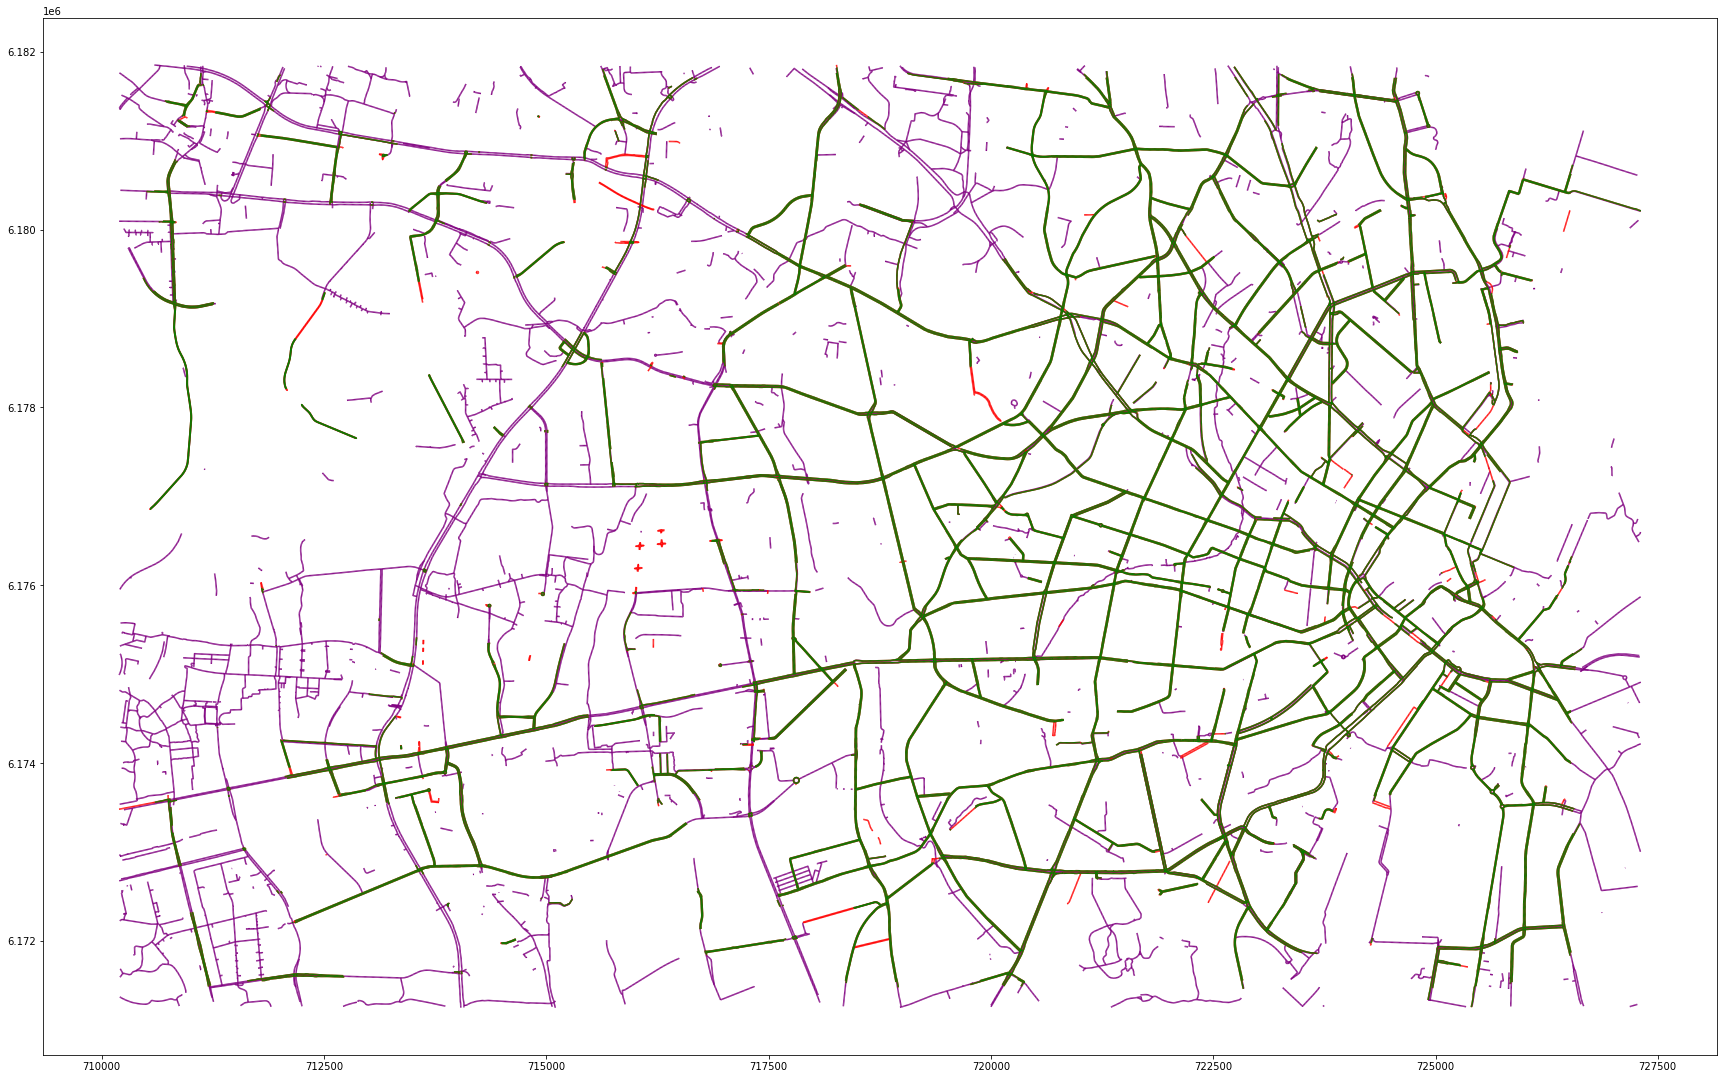

In [14]:
fig, ax = plt.subplots(figsize=(30,30))

osm_simplified_edges.plot(ax=ax, color='purple')
ref_simplified_edges.plot(ax=ax, color='red')
segment_matches.plot(ax=ax, color='green');

#TODO: folium plot, add legend

#### Matched features in the reference data

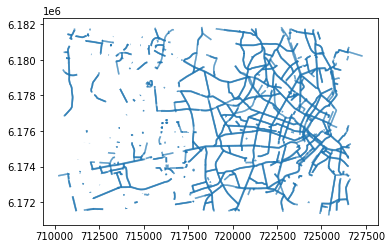

In [15]:
ref_matched_ids, ref_undec = mf.summarize_feature_matches(ref_segments, segment_matches, 'seg_id_ref','edge_id')
ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].plot();

#### Matched features in the OSM data

In [20]:
def summarize_feature_matches(segments, segment_matches, seg_id_col, edge_id_col):

    # TODO: WRITE TEST
 
    '''
    Determine whether a feature have been matched to a feature in the other dataset 
    based on how big a share of the feature's segments have been matched.
    If less than half of the length of a feature have been mapped, the match is considered incomplete.
    If half or more is matched, it is considered fully matched.

    Arguments:
        segments (gdf): gdf with data segments
        segment_matches (df): segment matches (result from find_matches_from_buffer())
        seg_id_col (str): column name with unique id of segments
        edge_id_col (str): column name with unique id of edges

    Returns:
        matched_ids (list): ids of features that have been consistently matched
        undecided_ids (list): ids of features that have not been completely matched
    '''

    # Create column to do join on
    segment_matches[seg_id_col] = segment_matches['matches_id']
    #Create dataframe with new and old ids and information on matches
    merged = segments.merge(segment_matches[[seg_id_col,'matches_ix','matches_id']], how ='left', on=seg_id_col)

    org_ids = list( merged[edge_id_col].unique() ) # Is edge id correct?

    matched_ids = []
    undecided_ids = []

    for i in org_ids:
        
        feature = merged.loc[merged[edge_id_col] == i].copy()

        # First check if all segments belonging to the id have been matched
        if len(feature.loc[feature.matches_id.isna()]) == 0:
            # If yes, mark as matched
            matched_ids.append(i)

        else:
            # Set matched as either True or False and compute length
            feature['length'] = feature.geometry.length
            feature['matched'] = None
            
            not_matched_ix = feature.loc[feature.matches_id.isna()].index
            matched_ix = feature.loc[feature.matches_id.notna()].index
            feature.loc[not_matched_ix, 'matched'] = False
            feature.loc[matched_ix, 'matched'] = True

            summed = feature.groupby('matched').agg({'length': 'sum'})

            majority_value = summed['length'].idxmax()
            
            majority_value_len = summed.loc[majority_value].values[0]

            # If the majority value represents less than half of the edges, mark as undecided
            if majority_value_len < summed.length.sum() / 100 * 50:

                undecided_ids.append(i)

            # If more than half and true, check value to see if it is a match
            else:
                if majority_value == True:
                    matched_ids.append(i)

                else:
                    continue

    return matched_ids, undecided_ids

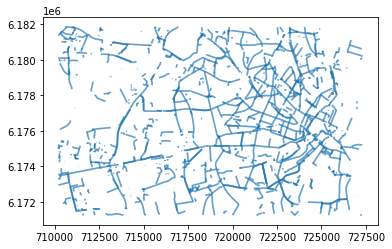

In [21]:
osm_matched_ids, osm_undec = summarize_feature_matches(osm_segments, segment_matches,'seg_id','osmid')
osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

#### Unmatched features in the OSM data

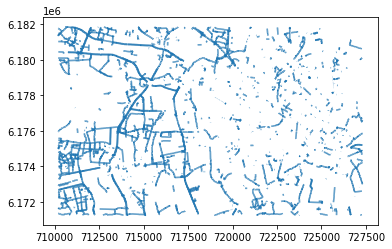

In [10]:
osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].plot();

#### Unmatched features in the reference data

In [ ]:
ref_simplified_edges.loc[~ref_simplified_edges.edge_id.isin(ref_matched_ids)].plot();

### Summarize results

In [11]:
count_matched_osm = len(osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)])
count_matched_ref = len(ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)])

print(f'Out of {len(osm_simplified_edges)} OSM edges, {count_matched_osm} were matched with a reference edge.')
print(f'Out of {len(ref_simplified_edges)} reference edges, {count_matched_ref} were matched with an OSM edge.')

length_matched_osm = osm_simplified_edges.loc[osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()
length_unmatched_osm = osm_simplified_edges.loc[~osm_simplified_edges.edge_id.isin(osm_matched_ids)].geometry.length.sum()

length_matched_ref = ref_simplified_edges.loc[ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()
length_unmatched_ref = ref_simplified_edges.loc[~ref_simplified_edges.edge_id.isin(ref_matched_ids)].geometry.length.sum()

print(f'Out of {osm_simplified_edges.geometry.length.sum()/1000:.2f} km of OSM edges, {length_matched_osm/1000:.2f} km were matched with a reference edge.')
print(f'Out of {ref_simplified_edges.geometry.length.sum()/1000:.2f} km of reference edges, {length_matched_ref/1000:.2f} km were matched with an OSM edge.')

results_feature_matching = {
    'osm_matched_count': count_matched_osm,
    'ref_matched_count': count_matched_ref,
    'osm_matched_length': length_matched_osm,
    'ref_matched_length': length_matched_ref
}

Out of 5437 OSM edges, 2466 were matched with a reference edge.
Out of 4208 reference edges, 3917 were matched with an OSM edge.
Out of 803.60 km of OSM edges, 420.57 km were matched with a reference edge.
Out of 623.52 km of reference edges, 600.58 km were matched with an OSM edge.


________________

## 3. Analyse feature matching results

### Compare infrastructure type in matched features

In [12]:
updated_osm = mf.update_osm(osm_segments, osm_simplified_edges, segment_matches, 'protected', 'edge_id','seg_id')

#### Plotting edges marked as *protected* infrastructure in both datasets

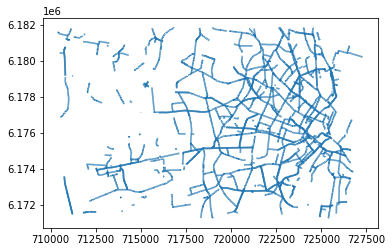

In [13]:
updated_osm.loc[updated_osm.protected == updated_osm.protected_matched].plot();

#### Plotting edges with differing classifications

In [ ]:
updated_osm.loc[updated_osm.protected != updated_osm.protected_matched].plot();


#### Count and measure length of matched and unmatched features per grid cell

In [14]:
osm_matched = osm_edges_s_j.loc[osm_edges_s_j.edge_id.isin(osm_matched_ids)]

osm_unmatched = osm_edges_s_j.loc[~osm_edges_s_j.edge_id.isin(osm_matched_ids)]

# Count features in each grid cell
all_data_osm = [osm_matched, osm_unmatched]
labels_osm = ['osm_matched','osm_unmatched']

for data, label in zip(all_data_osm, labels_osm):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')
    

ref_matched = ref_edges_s_j.loc[ref_edges_s_j.edge_id.isin(ref_matched_ids)]
ref_unmatched = ref_edges_s_j.loc[~ref_edges_s_j.edge_id.isin(ref_matched_ids)]

# Count features in each grid cell
all_data_ref = [ref_matched, ref_unmatched]
labels_ref = ['ref_matched','ref_unmatched']

for data, label in zip(all_data_ref, labels_ref):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

    df = ef.length_of_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how='left')

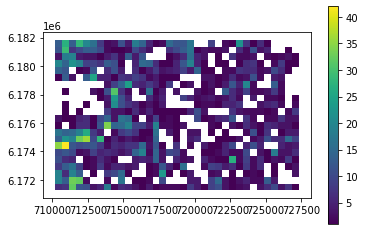

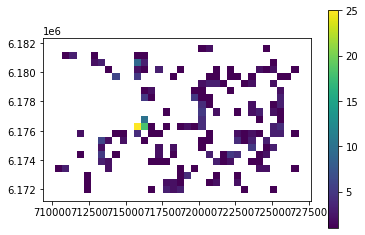

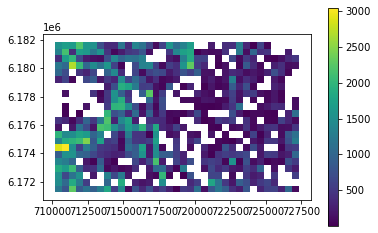

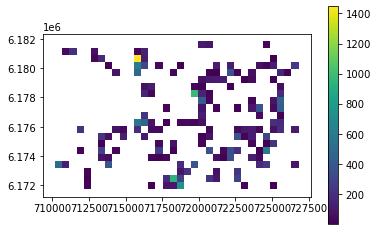

In [15]:
# TODO: Fix plots
grid.plot(column='count_osm_unmatched', legend=True);
grid.plot(column='count_ref_unmatched', legend=True);

grid.plot(column='length_osm_unmatched', legend=True);
grid.plot(column='length_ref_unmatched', legend=True);

____________________

## 4. Save results

In [16]:
with open(f'../results/feature_matches_{study_area}.json', 'w') as outfile:
    json.dump(results_feature_matching, outfile)

with open(f'../results/grid_results_feature_matching_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)